In [421]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score



In [422]:
hdf = pd.read_csv('kc_house_data.csv')
hdf = pd.DataFrame(hdf)

# hdf.info()



In [423]:
# remove variables we do not plan to use
hdf = hdf.drop(columns=['id','date','zipcode'])

# separate continous and categorical variables
continuous_hdf = hdf[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']]
categorical_hdf = hdf.drop(columns=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15'])

# restitch dataset but now with all continuous variables together
hdf = pd.concat([continuous_hdf, categorical_hdf], axis=1)

# hdf.to_csv('kc_house_reorganised.csv')




In [424]:
# make variables view, grade, condition binarised
hdf['view_b'] = hdf['view'] > 2
hdf['view_b'] = hdf['view_b'].astype(int)
hdf['condition_b'] = hdf['condition'] > 3
hdf['condition_b'] = hdf['condition_b'].astype(int)
hdf['grade_b'] = hdf['grade'] > 7
hdf['grade_b'] = hdf['grade_b'].astype(int)

# function to combine year built and year renovated into one binarised variable to see if house has been updated or created after 2000
def label_new(row):
    if row['yr_renovated'] > 2000 :
        return '1'
    elif row['yr_built'] > 2000 :
        return '1'
    else:
        return '0'

# def label_price_range(col):
#     if col['price'] < 250000 :
#         return '1'
#     elif col['price'] < 500000 :
#         return '2'
#     elif col['price'] < 750000 :
#         return '3'
#     elif col['price'] < 1000000 :
#         return '4'
#     elif col['price'] < 1500000 :
#         return '5'
#     elif col['price'] < 2000000 :
#         return '6'
#     elif col['price'] < 2500000 :
#         return '7'
#     elif col['price'] < 3000000 :
#         return '8'

price_pd = pd.DataFrame(hdf.copy().pop('price'))
# price_pd = hdf.copy().pop('price')
price_lab = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
price_pd['price_range'] = pd.cut(price_pd.price, [0, 250000, 500000, 750000, 1000000, 1500000, 2000000, 2500000, 3000000, 5000000, 8000000], labels=price_lab)
print(price_pd)
price_pd.to_excel('priceRange.xlsx')



hdf['is_new_or_renovated'] = hdf.apply(lambda row: label_new(row), axis=1)
hdf['is_new_or_renovated'] = hdf['is_new_or_renovated'].astype(int)

# print(hdf['is_new_or_renovated'])

hdf = hdf.drop(columns=['view','grade','condition','yr_built','yr_renovated'])




          price price_range
0      221900.0           A
1      538000.0           C
2      180000.0           A
3      604000.0           C
4      510000.0           C
...         ...         ...
21608  360000.0           B
21609  400000.0           B
21610  402101.0           B
21611  400000.0           B
21612  325000.0           B

[21613 rows x 2 columns]


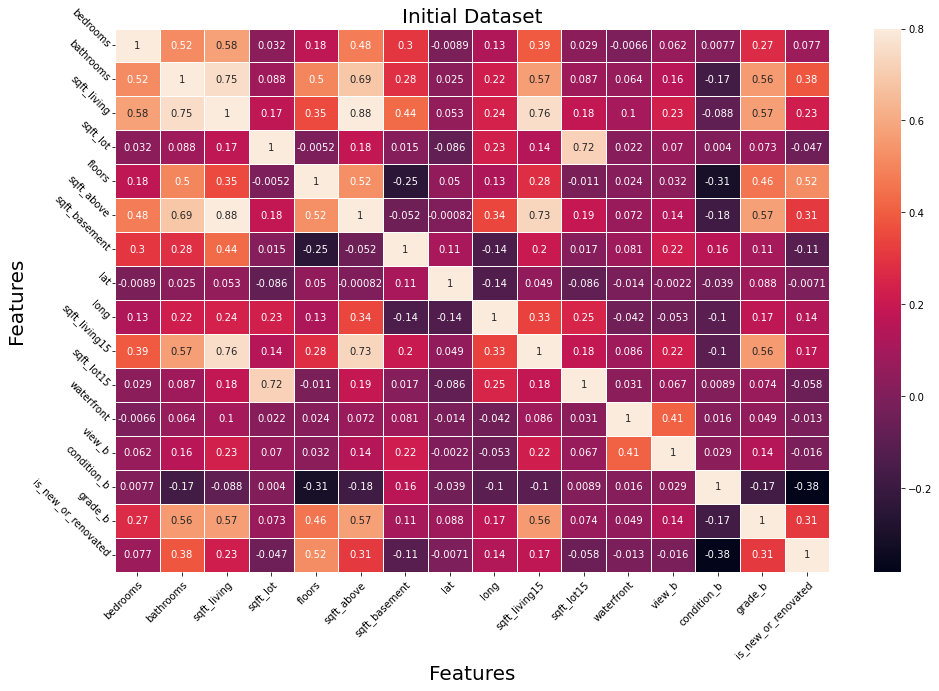

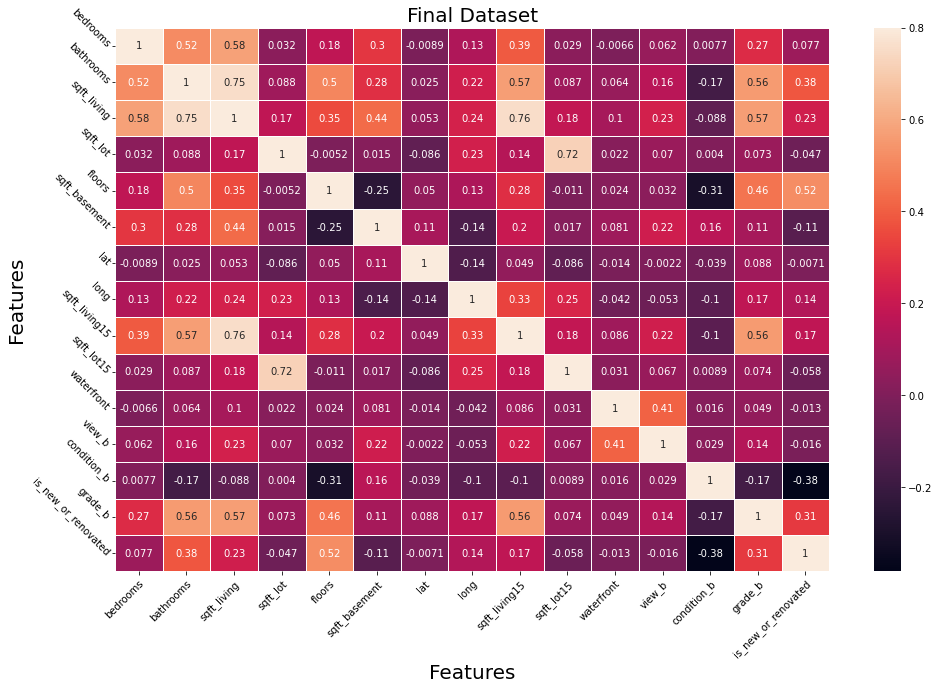

In [425]:
hdf_prepro = hdf.copy()

hdf_corr = hdf.copy()

columns = list(hdf_corr.columns)
y_col = columns.pop(0)

y = hdf_corr[y_col].to_numpy()
X = hdf_corr[columns].to_numpy()


scaler = MinMaxScaler()
hdf_corr[columns] = scaler.fit_transform(hdf_corr[columns])

hdf_corr = hdf_corr.drop(['price'], axis=1)

corrmat = hdf_corr.corr()

fig, ax = plt.subplots(figsize=[16,10])
sns.heatmap(corrmat,vmax=0.8, annot=True, linewidths=1, linecolor='white')
ax.set_xlabel('Features', fontsize = 20)    
ax.set_ylabel('Features', fontsize =20)
plt.title("Initial Dataset", fontsize = 20)  
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.setp(ax.get_yticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.show()

# There is a high correlation between sqft_living and sqft_above (0.88) so it was removed to reduce skew

hdf_corr = hdf_corr.drop(['sqft_above'], axis=1)

corrmat = hdf_corr.corr() 

fig, ax = plt.subplots(figsize=[16,10])
sns.heatmap(corrmat,vmax=0.8, annot=True, linewidths=1, linecolor='white')
ax.set_xlabel('Features', fontsize = 20)    
ax.set_ylabel('Features', fontsize =20)
plt.title("Final Dataset", fontsize = 20)  
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.setp(ax.get_yticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.show()

corrT = hdf_corr.corr(method = 'pearson').round(4)
# corrT = corrT.sort_values(by=['price'])
# corrT['price']

# print(hdf)

In [426]:
hdf_prepro['Price Range'] = price_pd['price_range']
hdf_prepro = hdf_prepro.drop(['sqft_above'], axis=1)

In [427]:
hdf_prepro.to_csv("KC_House_Processed_Data.csv")

In [428]:
train, other = train_test_split(hdf_prepro, test_size=0.2, random_state=0)
validation, test = train_test_split(hdf_prepro, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(hdf_prepro, test_size=0.2,random_state=0)
X_train = train.drop(['Price Range'], axis = 1)
y_train = train['Price Range']
X_val = validation.drop(['Price Range'], axis = 1)
y_val = validation['Price Range']
X_test = test.drop(['Price Range'], axis = 1)
y_test = test['Price Range']
X_train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront,view_b,condition_b,grade_b,is_new_or_renovated
5268,495000.0,3,1.0,1570,5510,1.0,500,47.6942,-122.319,1770,6380,0,0,1,0,0
16909,635000.0,3,2.5,1780,11000,1.0,570,47.5574,-122.149,2310,9700,0,0,1,1,0
16123,382500.0,3,1.5,1090,9862,1.0,0,47.6256,-122.036,1710,9862,0,0,0,1,0
12181,382500.0,4,2.5,2210,7079,2.0,0,47.4206,-122.183,1970,7000,0,0,0,1,0
12617,670000.0,3,2.5,1800,4763,2.0,560,47.6460,-122.362,1790,4763,0,0,0,0,0


In [429]:
means = X_train.mean(axis=0)
stds = X_train.std(axis=0)


X_train_standardised = (X_train - means) / stds
X_val_standardised = (X_val - means) / stds
X_test_standardised = (X_test - means) / stds

X_train_standardised.head()
# print(X_train_standardised['sqft_living'].std())
# print(X_test_standardised['sqft_living'].mean())

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront,view_b,condition_b,grade_b,is_new_or_renovated
5268,-0.128343,-0.390023,-1.448095,-0.553934,-0.230230,-0.917914,0.466341,0.964830,-0.744673,-0.316901,-0.232451,-0.090673,-0.200307,1.395306,-0.961610,-0.549848
16909,0.247558,-0.390023,0.494282,-0.326475,-0.100351,-0.917914,0.624130,-0.022009,0.463181,0.469978,-0.112885,-0.090673,-0.200307,1.395306,1.039863,-0.549848
16123,-0.430406,-0.390023,-0.800636,-1.073840,-0.127273,-0.917914,-0.660724,0.469968,1.266049,-0.404332,-0.107050,-0.090673,-0.200307,-0.716647,1.039863,-0.549848
12181,-0.430406,0.670275,0.494282,0.139273,-0.193112,0.925056,-0.660724,-1.008849,0.221611,-0.025464,-0.210123,-0.090673,-0.200307,-0.716647,1.039863,-0.549848
12617,0.341533,-0.390023,0.494282,-0.304813,-0.247902,0.925056,0.601588,0.617128,-1.050189,-0.287757,-0.290686,-0.090673,-0.200307,-0.716647,-0.961610,-0.549848


In [430]:
rfc  = RandomForestClassifier(max_depth=6, min_samples_split=10)
rfc = rfc.fit(X_train_standardised, y_train)

ypred_val = rfc.predict(X_val_standardised)
ypred_test = rfc.predict(X_test_standardised)

acc_val = accuracy_score(y_val, ypred_val)
prec_val = precision_score(y_val, ypred_val, average='weighted', zero_division=0)
rec_val = recall_score(y_val, ypred_val, average='weighted')

acc_test = accuracy_score(y_test, ypred_test)
prec_test = precision_score(y_test, ypred_test, average='weighted', zero_division=0)
rec_test = recall_score(y_test, ypred_test, average='weighted')

print('Validation Precision:{}'.format(prec_val))
print('Validation Accuracy:{}'.format(acc_val))
print('Validation Recall:{}'.format(rec_val))


print('Test Precision:{}'.format(prec_test))
print('Test Accuracy:{}'.format(acc_test))
print('Test Recall:{}'.format(rec_test))



Validation Precision:0.962880786583947
Validation Accuracy:0.9725152692948362
Validation Recall:0.9725152692948362
Test Precision:0.9603167169756459
Test Accuracy:0.970389562320718
Test Recall:0.970389562320718
